In [67]:
import json
import base64
import gzip
import os
import shutil
import pandas as pd
import copy
from pathlib import Path
from typing import Union
from collections import defaultdict

In [9]:
DRAW_COMMANDS = [
    "drawArrays",
    "drawElements",
    "drawArraysInstanced",
    "drawArraysInstancedANGLE",
    "drawElementsInstanced",
    "drawElementsInstancedANGLE",
    "drawRangeElements",
    "multiDrawArraysWEBGL",
    "multiDrawElementsWEBGL",
    "multiDrawArraysInstancedWEBGL",
    "multiDrawElementsInstancedWEBGL",
    "multiDrawArraysInstancedBaseInstanceWEBGL",
    "multiDrawElementsInstancedBaseVertexBaseInstanceWEBGL",
]

STATES = [
    "BlendState",
    "ColorState",
    "CoverageState",
    "CullState",
    "DepthState",
    "DrawState",
    "PolygonOffsetState",
    "ScissorState",
    "StencilState",
    "VisualState",
    "DrawCall"
]

PURGE_KEYS = [
    'value',
    'values',
    'displayText',
    "source",
    'name',
#     'src',
]

In [69]:
def purge(co: Union[dict,list,int,str,float,bool,None]):
    if co is None:
        return None
    if isinstance(co, str):
        if co.startswith('data:') and 'base64' in co:
            return co.split(',')[0]
    if isinstance(co, (int, str, float, bool)):
        return co
    if isinstance(co, list):
        return [purge(x) for x in co]
    if isinstance(co, dict):
#         ret = {k: purge(v) for k, v in co.items() if k not in PURGE_KEYS and 'CommandId' not in k}
        ret = {k: purge(v) for k, v in co.items() if k not in PURGE_KEYS and not k.startswith("__SPECTOR") and 'CommandId' not in k}
        ret = {k: v for k, v in ret.items() if (not isinstance(v, (list, dict))) or (len(v) > 0)}
    return ret

In [70]:
# obj = json.load(gzip.open('output/TEST-1_0_0.json.gz', 'rt'))

def get_duplicity_of_pipeline(obj):
    possible_pipelines_set = defaultdict(lambda : { "pipeline": set(), "before": 0 })
    for cmd in obj['commands']:
        if cmd['name'] in DRAW_COMMANDS:
            vv = purge({k: cmd[k] for k in STATES})
#             vv = {k: cmd[k] for k in STATES}
            possible_pipelines_set[cmd['name']]["before"] += 1
            possible_pipelines_set[cmd['name']]["pipeline"].add(json.dumps(vv, sort_keys=True, separators=(",", ":"), indent=None))
    return [{"command": k, "pipelines": list(v["pipeline"]), "before": v["before"], "after": len(v["pipeline"])} for k, v in possible_pipelines_set.items()]

In [71]:
if Path("imr/0504-df_pipeline.pkl.zst").exists():
    df_pipeline = pd.read_pickle("imr/0504-df_pipeline.pkl.zst", compression='zstd')
else:
    df = pd.read_pickle('imr/0504-df_spector.pkl.zst', compression='zstd')
    df_dup = df['frame.data'].map(get_duplicity_of_pipeline)
    df_a = df.copy()
    df_a['frame.data'] = df_dup
    df_a = df_a.explode('frame.data').reset_index(drop=False).rename(columns={'index': 'idx-context'})
    df_b = df_a.drop(columns='frame.data').join(pd.json_normalize(df_a['frame.data']).add_prefix('frame.data.'))
    df_b['frame.data.ratio'] = df_b['frame.data.after'] / df_b['frame.data.before']
    df_pipeline = df_b
    df_pipeline.to_pickle("imr/0504-df_pipeline.pkl.zst", compression='zstd')

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper", font_scale=3)
sns.set_palette("deep")
color_palette = sns.color_palette()
color_palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

## Duplicity

       frame.data.ratio  frame.data.before  frame.data.after
count       4952.000000        4952.000000       4952.000000
mean           0.654877          37.435985          6.014943
std            0.393454         109.165552         18.741224
min            0.000556           1.000000          1.000000
50%            1.000000           3.000000          2.000000
90%            1.000000          84.900000         11.000000
99%            1.000000         577.960000         77.000000
max            1.000000        1800.000000        404.000000


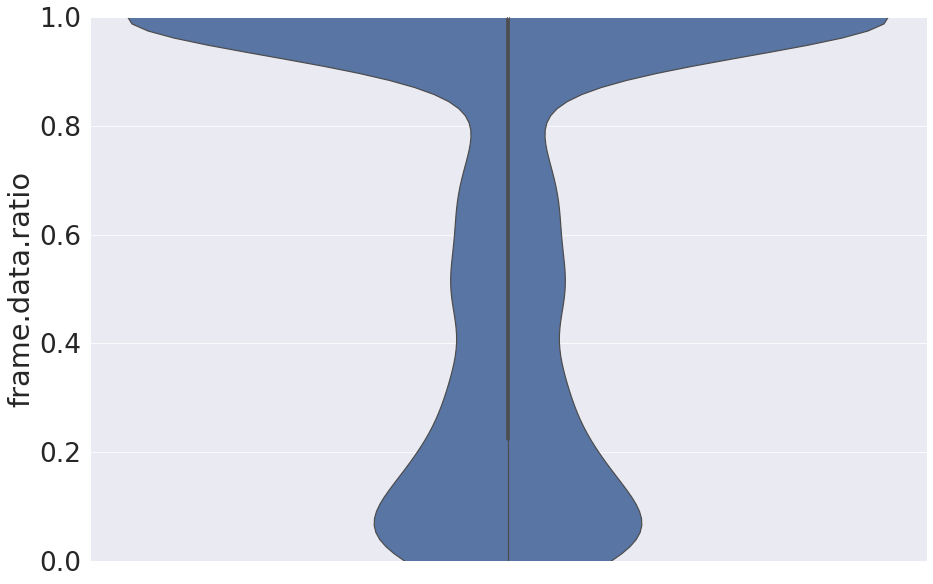

In [73]:
plt.ylim((0,1))
sns.violinplot(df_pipeline, y='frame.data.ratio')
plt.plot()
print(df_pipeline[['frame.data.ratio', 'frame.data.before', 'frame.data.after']].describe(percentiles=[0.5, 0.9, 0.99]))

<AxesSubplot:xlabel='frame.data.command', ylabel='frame.data.ratio'>

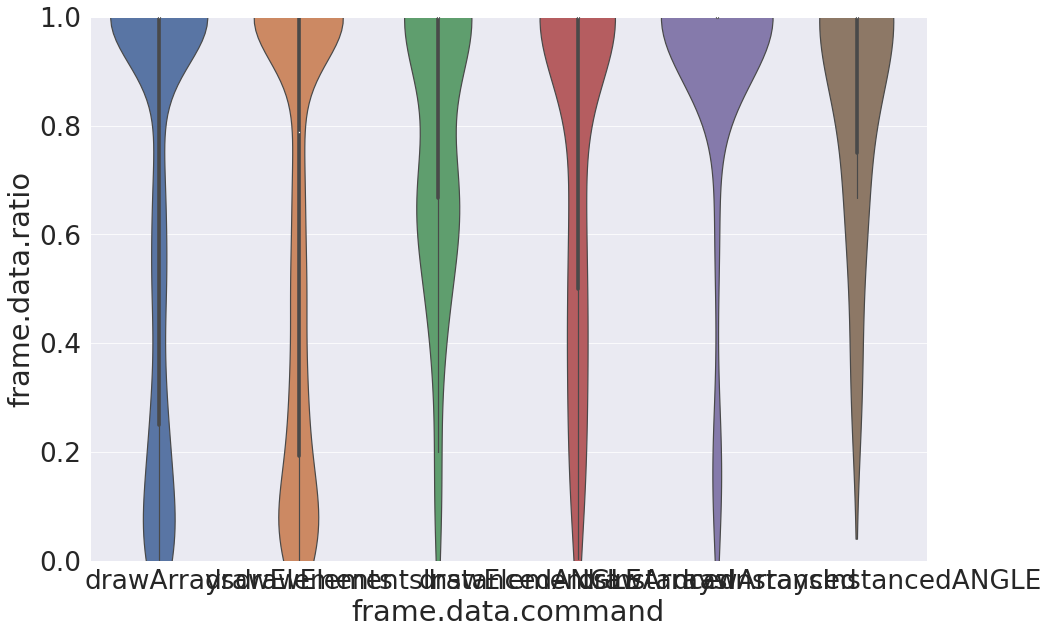

In [74]:
plt.ylim((0,1))
sns.violinplot(df_pipeline, x='frame.data.command', y='frame.data.ratio')

In [75]:
df_b = df_pipeline.copy()
df_b['frame.data.metric'] = df_b.apply(lambda x: [{"type": "Before De-dup.", "value": x["frame.data.before"]}, {"type": "After De-dup.", "value": x["frame.data.after"]}], axis=1)
df_c = df_b.explode('frame.data.metric')
df_c = df_c.drop(columns='frame.data.metric').join(pd.json_normalize(df_c['frame.data.metric']).add_prefix('frame.data.metric.'))
df_c['frame.data.command'].replace({
    'drawArrays': 'DA',
    'drawElements': 'DE',
    'drawElementsInstancedANGLE': 'DEIA',
    'drawElementsInstanced': 'DEI',
    'drawArraysInstanced': 'DAI',
    'drawArraysInstancedANGLE': 'DAIA',
}, inplace=True)

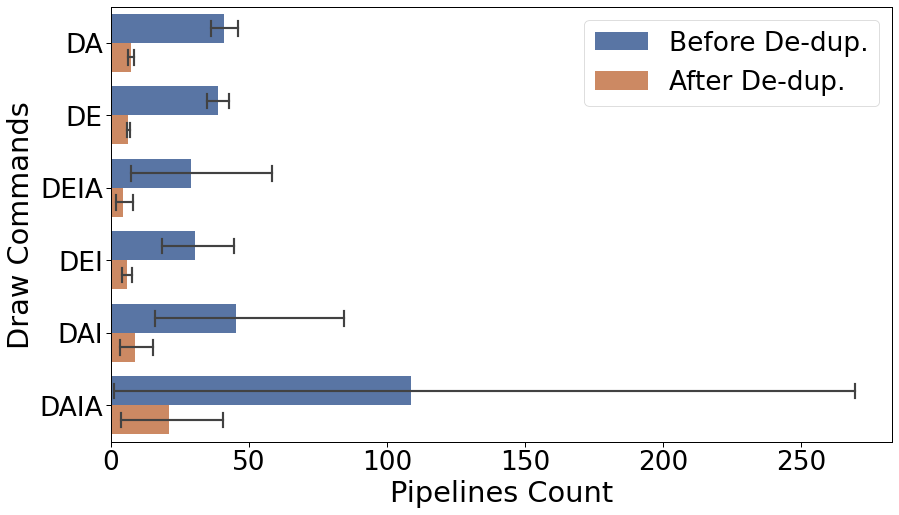

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(df_c, x='frame.data.metric.value', y='frame.data.command', hue='frame.data.metric.type', capsize=.2) #, estimator=sum)
plt.ylabel("Draw Commands")
plt.xlabel("Pipelines Count")
plt.legend().set_title("")
plt.savefig('fig/results_pipeline_dup.pdf', format="pdf", bbox_inches="tight")

<Figure size 1008x720 with 0 Axes>

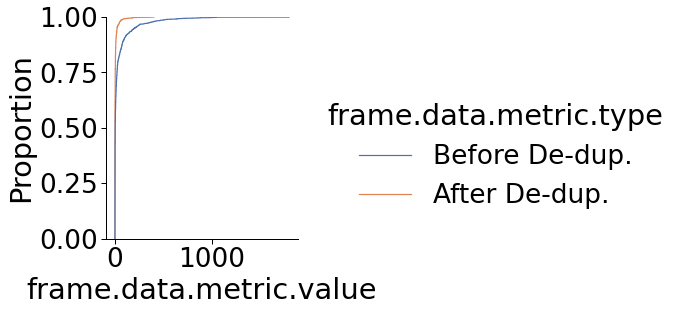

In [ ]:
plt.figure(figsize=(14, 10))
sns.displot(df_c.reset_index(), x='frame.data.metric.value', hue='frame.data.metric.type', kind="ecdf")

## Complexity

### resources count in draw

In [ ]:
if Path("imr/0504-df_pipeline-detail.pkl.zst").exists():
    df_pipeline_detail = pd.read_pickle("imr/0504-df_pipeline-detail.pkl.zst", compression='zstd')
else:
    df_a = df_pipeline.explode('frame.data.pipelines').drop(columns=['frame.data.before','frame.data.after','frame.data.ratio']).dropna(subset='frame.data.pipelines')
    df_a['frame.data.pipelines'] = df_a['frame.data.pipelines'].map(lambda x: json.loads(x))
    df_pipeline_detail = df_a.drop(columns='frame.data.pipelines').join(pd.json_normalize(df_a['frame.data.pipelines'], max_level=0).add_prefix('frame.data.pipeline.'))
    df_pipeline_detail.to_pickle("imr/0504-df_pipeline-detail.pkl.zst", compression='zstd')    

In [ ]:
df_pipeline_detail

,idx-context,idx-frame,idx,url,date,netIdleTimeout,spec_path,frame.url,frame.data.command,frame.data.pipeline.BlendState,frame.data.pipeline.ColorState,frame.data.pipeline.CoverageState,frame.data.pipeline.CullState,frame.data.pipeline.DepthState,frame.data.pipeline.DrawCall,frame.data.pipeline.DrawState,frame.data.pipeline.PolygonOffsetState,frame.data.pipeline.ScissorState,frame.data.pipeline.StencilState,frame.data.pipeline.VisualState
0,0,0,00000,http://0ldsk00l.ca/,1683084643202,0,../2-9.playwright/output/spector-one/00000.json,http://0ldsk00l.ca/,drawArrays,"{'BLEND': False, 'BLEND_COLOR': [0, 0, 0, 0], ...","{'COLOR_WRITEMASK': [True, True, True, True]}","{'SAMPLE_ALPHA_TO_COVERAGE': False, 'SAMPLE_CO...","{'CULL_FACE': True, 'CULL_FACE_MODE': 'BACK'}","{'DEPTH_FUNC': 'LEQUAL', 'DEPTH_RANGE': [0, 1]...","{'attributes': [{'arraySize': 3, 'arrayType': ...","{'DITHER': True, 'FRAGMENT_SHADER_DERIVATIVE_H...","{'POLYGON_OFFSET_FACTOR': 0, 'POLYGON_OFFSET_F...","{'SCISSOR_BOX': [0, 0, 300, 150], 'SCISSOR_TES...","{'STENCIL_BACK_FAIL': 'KEEP', 'STENCIL_BACK_FU...",{'Attachments': [{'attachmentName': 'Canvas CO...
1,1,15,00011,http://12storytellers.hands.agency,1683084677986,1,../2-9.playwright/output/spector-one/00011.json,https://12storytellers.hands.agency/,drawElements,"{'BLEND': False, 'BLEND_COLOR': [0, 0, 0, 0], ...","{'COLOR_WRITEMASK': [True, True, True, True]}","{'SAMPLE_COVERAGE_INVERT': False, 'SAMPLE_COVE...","{'CULL_FACE': True, 'CULL_FACE_MODE': 'BACK'}","{'DEPTH_FUNC': 'LESS', 'DEPTH_RANGE': [0, 1], ...","{'attributes': [{'arraySize': 3, 'arrayType': ...","{'DITHER': True, 'FRAGMENT_SHADER_DERIVATIVE_H...","{'POLYGON_OFFSET_FACTOR': 0, 'POLYGON_OFFSET_F...","{'SCISSOR_BOX': [0, 0, 1280, 720], 'SCISSOR_TE...","{'STENCIL_BACK_FAIL': 'KEEP', 'STENCIL_BACK_FU...",{'Attachments': [{'attachmentName': 'Canvas CO...
1,1,15,00011,http://12storytellers.hands.agency,1683084677986,1,../2-9.playwright/output/spector-one/00011.json,https://12storytellers.hands.agency/,drawElements,"{'BLEND': False, 'BLEND_COLOR': [0, 0, 0, 0], ...","{'COLOR_WRITEMASK': [True, True, True, True]}","{'SAMPLE_COVERAGE_INVERT': False, 'SAMPLE_COVE...","{'CULL_FACE': True, 'CULL_FACE_MODE': 'BACK'}","{'DEPTH_FUNC': 'LESS', 'DEPTH_RANGE': [0, 1], ...","{'attributes': [{'arraySize': 3, 'arrayType': ...","{'DITHER': True, 'FRAGMENT_SHADER_DERIVATIVE_H...","{'POLYGON_OFFSET_FACTOR': 0, 'POLYGON_OFFSET_F...","{'SCISSOR_BOX': [0, 0, 1280, 720], 'SCISSOR_TE...","{'STENCIL_BACK_FAIL': 'KEEP', 'STENCIL_BACK_FU...",{'Attachments': [{'attachmentName': 'Canvas CO...
1,1,15,00011,http://12storytellers.hands.agency,1683084677986,1,../2-9.playwright/output/spector-one/00011.json,https://12storytellers.hands.agency/,drawElements,"{'BLEND': False, 'BLEND_COLOR': [0, 0, 0, 0], ...","{'COLOR_WRITEMASK': [True, True, True, True]}","{'SAMPLE_COVERAGE_INVERT': False, 'SAMPLE_COVE...","{'CULL_FACE': True, 'CULL_FACE_MODE': 'BACK'}","{'DEPTH_FUNC': 'LESS', 'DEPTH_RANGE': [0, 1], ...","{'attributes': [{'arraySize': 3, 'arrayType': ...","{'DITHER': True, 'FRAGMENT_SHADER_DERIVATIVE_H...","{'POLYGON_OFFSET_FACTOR': 0, 'POLYGON_OFFSET_F...","{'SCISSOR_BOX': [0, 0, 1280, 720], 'SCISSOR_TE...","{'STENCIL_BACK_FAIL': 'KEEP', 'STENCIL_BACK_FU...",{'Attachments': [{'attachmentName': 'Canvas CO...
1,1,15,00011,http://12storytellers.hands.agency,1683084677986,1,../2-9.playwright/output/spector-one/00011.json,https://12storytellers.hands.agency/,drawElements,"{'BLEND': False, 'BLEND_COLOR': [0, 0, 0, 0], ...","{'COLOR_WRITEMASK': [True, True, True, True]}","{'SAMPLE_COVERAGE_INVERT': False, 'SAMPLE_COVE...","{'CULL_FACE': True, 'CULL_FACE_MODE': 'BACK'}","{'DEPTH_FUNC': 'LESS', 'DEPTH_RANGE': [0, 1], ...","{'attributes': [{'arraySize': 3, 'arrayType': ...","{'DITHER': True, 'FRAGMENT_SHADER_DERIVATIVE_H...","{'POLYGON_OFFSET_FACTOR': 0, 'POLYGON_OFFSET_F...","{'SCISSOR_BOX': [0, 0, 1280, 720], 'SCISSOR_TE...","{'STENCIL_BACK_FAIL': 'KEEP', 'STENCIL_BACK_FU...",{'Attachments': [{'att

### assemble distance

In [4]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [40]:
df_spector = pd.read_pickle('imr/0504-df_spector.pkl.zst', compression='zstd')

In [39]:
# plot average_distance_between_draw
sns.set_context("paper", font_scale=2)
sns.set_palette("deep")
color_palette = sns.color_palette()
color_palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

In [50]:
def get_distance_between_draw(x):
    cur = 0
    draws = 0
    lst = []
    for cmd in x['commands']:
        if cmd['name'] in DRAW_COMMANDS:
            lst.append(cur)
            cur = 0
            draws += 1
        else:
            cur += 1
    if cur > 0:
        lst.append(cur)
    if len(lst) == 0:
        return None
    return {
        'mean': np.mean(lst),
        'first': lst[0],
        # 'std': np.std(lst),
        'min': np.min(lst),
        'max': np.max(lst),
        # 'median': np.median(lst),
        # 'count': len(lst),
        'sum': np.sum(lst),
        'draws': draws,
        'max_ratio': np.max(lst) * draws / np.sum(lst),
        'first_ratio': lst[0] * draws / np.sum(lst),
        'first_over_max': lst[0] / np.max(lst),
    }

In [51]:
distance_between_draw = pd.json_normalize(df_spector['frame.data'].map(get_distance_between_draw))
distance_between_draw

,mean,first,min,max,sum,draws,max_ratio,first_ratio,first_over_max
0,2.166667,4,2,4,26,12,1.846154,1.846154,1.00000
1,19.400000,20,3,387,1940,99,19.748969,1.020619,0.05168
2,12.591837,89,4,89,617,48,6.923825,6.923825,1.00000
3,35.200000,54,26,54,176,5,1.534091,1.534091,1.00000
4,17.000000,24,6,24,51,2,0.941176,0.941176,1.00000
...,...,...,...,...,...,...,...,...,...
3962,16.000000,24,3,24,48,2,1.000000,1.000000,1.00000
3963,12.192308,75,4,75,634,51,6.033123,6.033123,1.00000
3964,8.897436,23,8,23,347,39,2.585014,2.585014,1.00000
3965,7.923077,27,1,27,103,13,3.407767,3.407767,1.00000


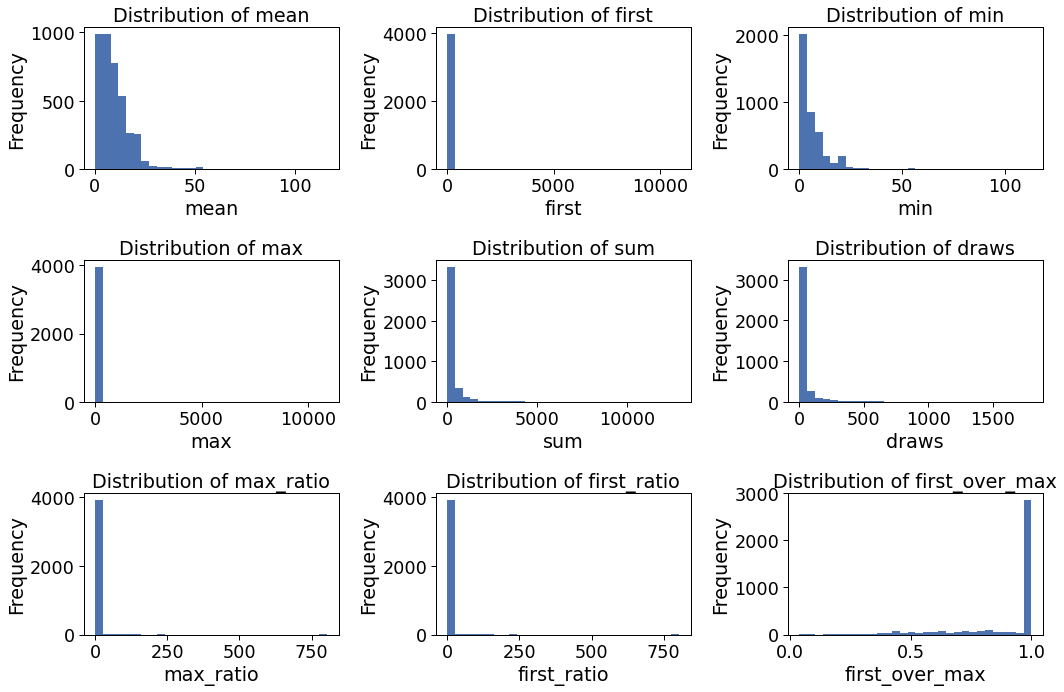

In [52]:
# Get the column names
columns = distance_between_draw.columns

# Create a set of subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Flatten the subplots array
axs = axs.ravel()

# Iterate over the columns and plot the distributions
for i, column in enumerate(columns):
    # Extract the column values
    column_values = distance_between_draw[column]

    # Create a histogram of the column values
    axs[i].hist(column_values, bins=30)

    # Add labels and title to the plot
    axs[i].set_xlabel(column)
    axs[i].set_ylabel("Frequency")
    axs[i].set_title(f"Distribution of {column}")

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()

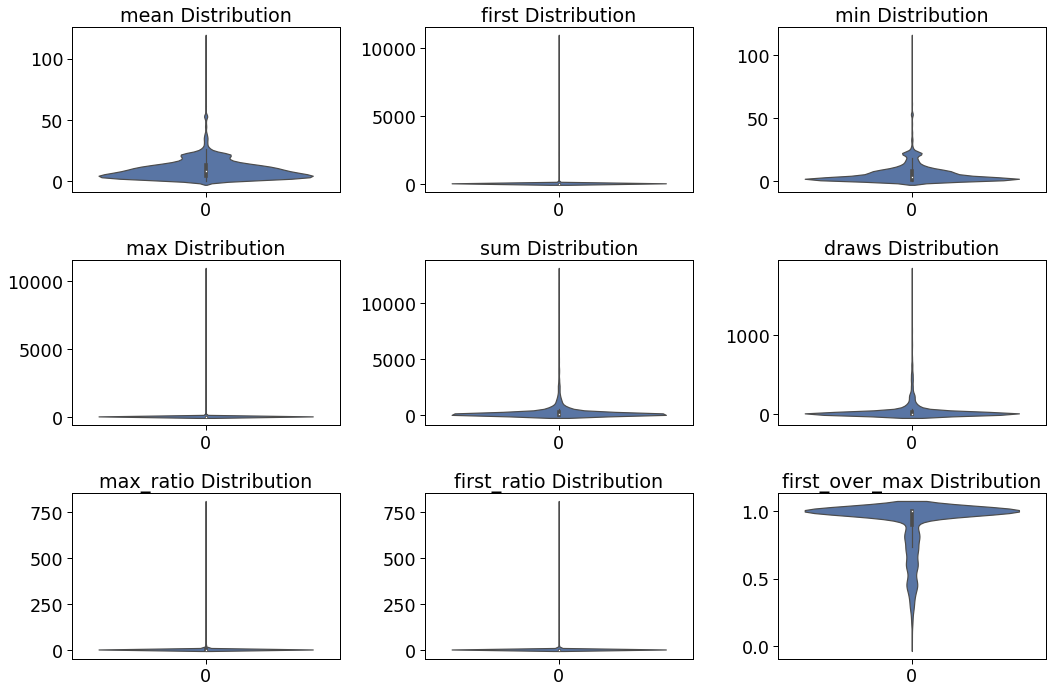

In [53]:
# Get the column names
columns = distance_between_draw.columns

# Create a set of subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))

# Flatten the subplots array
axs = axs.ravel()

# Iterate over the columns and plot the distributions
for i, column in enumerate(columns):
    # Extract the column values
    column_values = distance_between_draw[column]

    # Create a violin plot of the column values
    sns.violinplot(data=column_values, inner="box", ax=axs[i])

    # Set the title of the subplot
    axs[i].set_title(f"{column} Distribution")

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.show()

In [54]:
((distance_between_draw['first_ratio'] >= 2)).sum() / len(distance_between_draw)

0.28636249054701285

In [55]:
distance_between_draw.sort_values(by='first_ratio', ascending=False).head(10)

,mean,first,min,max,sum,draws,max_ratio,first_ratio,first_over_max
2593,2.775593,2232,1,2232,4094,1474,803.607230,803.607230,1.0
630,49.646154,10891,6,10891,12908,259,218.528742,218.528742,1.0
1883,27.188732,4216,2,4216,9652,355,155.064235,155.064235,1.0
673,2.924107,447,1,447,1310,447,152.525954,152.525954,1.0
2442,9.038760,1313,1,1313,5830,644,145.038079,145.038079,1.0
694,0.248566,30,0,30,130,523,120.692308,120.692308,1.0
1196,4.046154,377,2,377,789,195,93.174905,93.174905,1.0
1683,2.461207,181,0,181,1142,463,73.382662,73.382662,1.0
150,2.662309,183,1,183,1222,458,68.587561,68.587561,1.0
1245,6.874459,449,3,449,3176,461,65.172859,65.172859,1.0


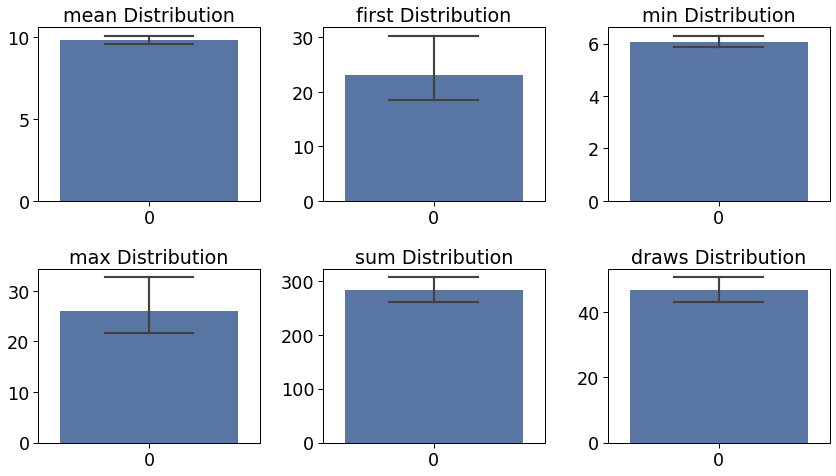

In [70]:
# Get the column names
columns = distance_between_draw.columns

# Create a set of subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 7))

# Flatten the subplots array
axs = axs.ravel()

# Iterate over the columns and plot the distributions
for i, column in enumerate(columns[:6]):
    # Extract the column values
    column_values = distance_between_draw[column]

    # Create a violin plot of the column values
    sns.barplot(data=column_values, ax=axs[i], capsize=.4)

    # Set the title of the subplot
    axs[i].set_title(f"{column} Distribution")

# Adjust the layout of the subplots
plt.tight_layout()

# Show the plot
plt.savefig('fig/results_spector.pdf', format="pdf", bbox_inches="tight")

In [60]:
tmp = distance_between_draw[distance_between_draw['draws']>1]

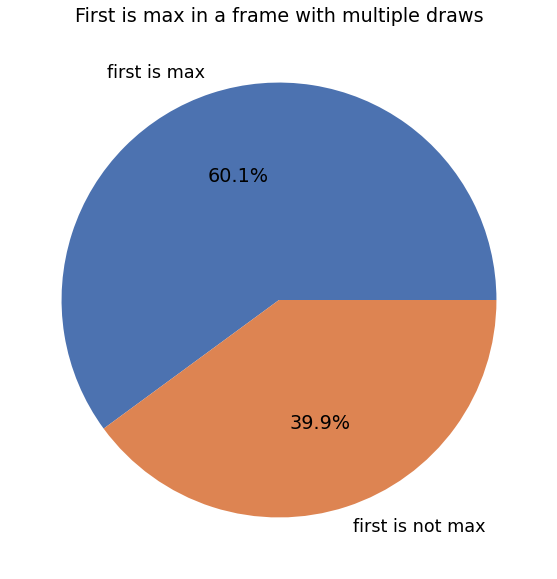

In [62]:
first_is_max_in_multiple_draw = (tmp['first'] == tmp['max']).sum() / len(tmp)
# pie plot
plt.figure(figsize=(14, 10))
plt.pie([first_is_max_in_multiple_draw, 1-first_is_max_in_multiple_draw], labels=['first is max', 'first is not max'], autopct='%1.1f%%')
plt.title('First is max in a frame with multiple draws')
plt.savefig('fig/results_spector_first_is_max_in_multiple_draw.pdf', format="pdf", bbox_inches="tight")